In [1]:
%pip install -v Mathics3 pymathics-graph ipywidgets lxml pyocr scikit-image unidecode wordcloud
%load_ext mathics.frontend.jupyter

/lib/python3.12/site-packages/mathics/builtin/quantum_mechanics/angular.py:89: SyntaxWarning: invalid escape sequence '\['
  """


In [2]:
Graphics[Table[{Hue[h, s], Disk[{12h, 8s}]}, {h, 0, 1, 1/6}, {s, 0, 1, 1/4}]]

In [3]:
Plot[{Sin[x], Cos[x], x ^ 2}, {x, -1, 1}]

In [4]:
f[x_] := 4 x / (x ^ 2 + 3 x + 5);
{f'[x], f''[x], f'''[x]} // Together

<IPython.core.display.Math object>

In [5]:
Graphics[Table[{EdgeForm[{GrayLevel[0, 0.5]}], Hue[(-11+q+10r)/72, 1, 1, 0.6], Disk[(8-r){Cos[2Pi q/12], Sin[2Pi q/12]}, (8-r)/3]}, {r, 6}, {q, 12}]]


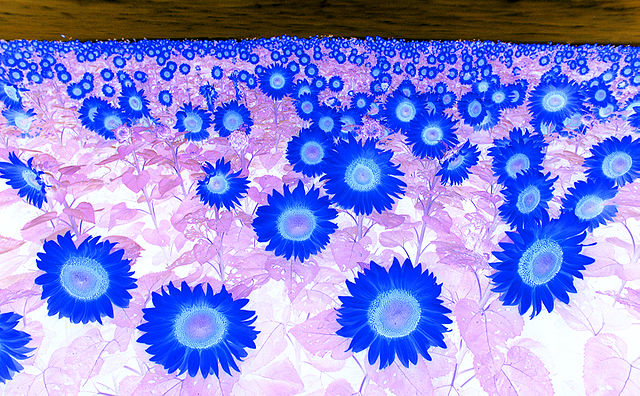

In [6]:
ColorNegate[Import["ExampleData/sunflowers.jpg"]] // MathMLForm

In [7]:
DominantColors[Import["ExampleData/hedy.tif"]] // MathMLForm

In [8]:
Graphics[Table[{AbsoluteThickness[t], Line[{{20 t, 10}, {20 t, 80}}], Text[ToString[t]<>"pt", {20 t, 0}]}, {t, 0, 10}]]

In [9]:
Table[Graphics[{Circle[], Arrow[Table[{Cos[phi],Sin[phi]},{phi,0,2*Pi,Pi/2}],{d, d}]}],{d,0,2,0.5}] // MathMLForm

In [10]:
Table[Style[Graphics[{EdgeForm[{Black}], RGBColor[r,g,b], Rectangle[]}], ImageSizeMultipliers->{0.2, 1}], {r,0,1,1/2}, {g,0,1,1/2}, {b,0,1,1/2}] // TableForm // MathMLForm

In [11]:
collatz[1] := 1;
collatz[x_ ? EvenQ] := x / 2;
collatz[x_] := 3 x + 1;
list = FixedPointList[collatz, 14];
ListLinePlot[list]

In [12]:
vertices = {{0,0}, {1,0}, {.5, .5 Sqrt[3]}};
points = NestList[.5(vertices[[ RandomInteger[{1,3}] ]] + #)&, {0.,0.}, 1000];
Graphics[Point[points], ImageSize->Large]

In [13]:
ListLinePlot[Table[Sin[x], {x, -5, 5, 0.2}], Filling->Axis]

In [14]:
DensityPlot[Sin[x y], {x, -2, 2}, {y, -2, 2}, Mesh->Full]

In [15]:
ParametricPlot[{Sin[u], Cos[3 u]}, {u, 0, 2 Pi}]

In [16]:
Clear[t]; PolarPlot[{1, 1 + Sin[20 t] / 5}, {t, 0, 2 Pi}]


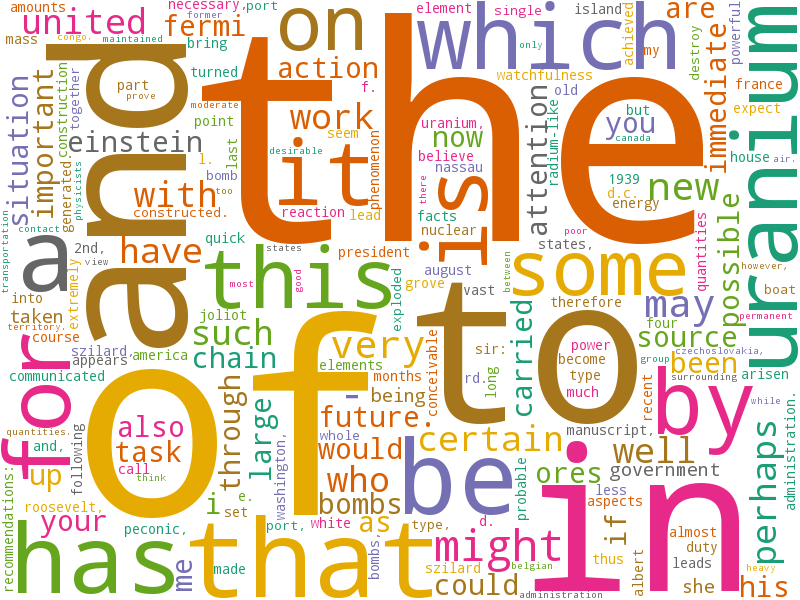

In [17]:
WordCloud[StringSplit[Import["ExampleData/EinsteinSzilLetter.txt", CharacterEncoding->"UTF8"]]] // MathMLForm


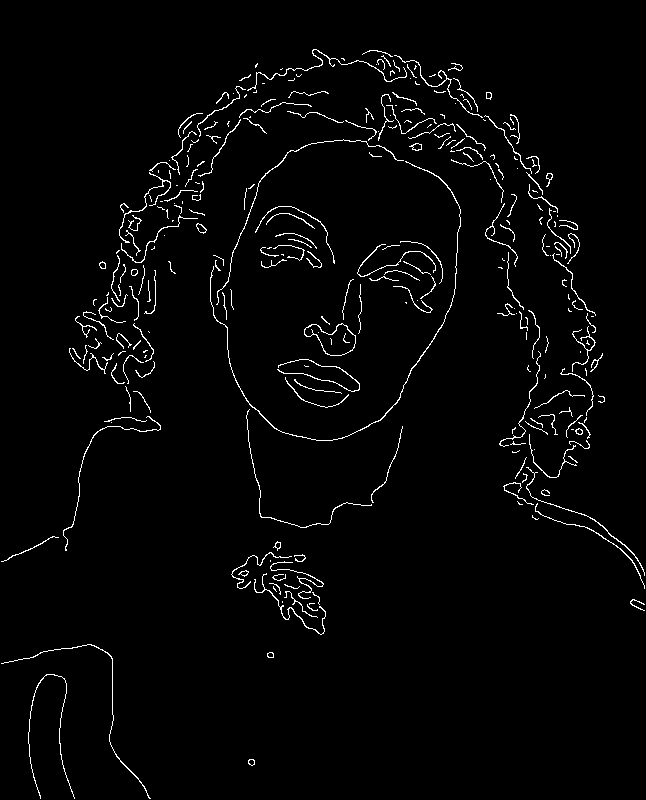

In [18]:
EdgeDetect[Import["ExampleData/hedy.tif"], 5] // MathMLForm

In [19]:
Apart[1 / (x^2 - y^2), x]

<IPython.core.display.Math object>

In [20]:
With[{f = {Cos[x] + Sin[x], Sin[x]}}, 
 Graphics[
  Table[{Hue[t/(2 Pi), 1, .8], Line[{f, Normalize[D[f, x]] + f}]} /. 
    x -> t, {t, 0, 2 Pi, .1}]]]

In [21]:
Integrate[Sin[x] ^ 5, x]

<IPython.core.display.Math object>

In [22]:
Series[Exp[x-y], {x, 0, 2}, {y, 0, 2}]

<IPython.core.display.Math object>

In [23]:
Graphics[
 Table[{EdgeForm[Black], Hue[RandomReal[]], 
   Disk[RandomReal[4, {2}], RandomReal[1]]}, {40}]]

In [24]:
Graphics[
 Table[{Hue[t/15, 1, .9, .3], 
   Disk[{Cos[2 Pi t/15], Sin[2 Pi t/15]}]}, {t, 15}]]

In [25]:
Graphics[{Red, Disk[{0, 0}, 2, {0, Pi}], Blue, 
    Disk[{0, 0}, 2, {Pi, 2 Pi}], Red, Disk[{-1, 0}, 1], Blue, 
    Disk[{1, 0}, 1]}, ImageSize -> 150]

In [26]:
Solve[{3 x ^ 2 - 3 y == 0, 3 y ^ 2 - 3 x == 0}, {x, y}] // Simplify

<IPython.core.display.Math object>

In [27]:
Graphics[Line[AnglePath[RandomReal[{-1, 1}, {100}]]]]

In [28]:
Nest[Subsuperscript[#,#,#]&,0,5]

<IPython.core.display.Math object>

In [29]:
lindenmayer[i_, b_, h_, j_, r_, n_] :=
 (a = h; p = j; s = k = {}; t = Flatten;
  (Switch[#,
      6, s = {a, p, s},
      8, {a, p, s} = s,
      _C, k = {k, Line@{p, p += {Cos@a, Sin@a}}}];
     If[# < 9, a += I^# b ]) & /@ t@Nest[# /. r &, i, n];
  Graphics@t@k);
lindenmayer[{C[1], X}, Pi/2, 0, {0, 0}, {X -> {X, 4, Y, C[1]}, Y -> {C[1], X, 2, Y}}, 10]

In [30]:
ListPlot[Table[ElementData[z, "AtomicWeight"], {z, 118}]]

In [31]:
Clear[a]; RSolve[{a[n + 2] == a[n], a[0] == 1, a[1] == 4}, a, n]

<IPython.core.display.Math object>

In [32]:
LoadModule["pymathics.graph"]

pymathics.graph

In [33]:
CompleteGraph@20

In [34]:
BinomialTree[3, DirectedEdges->True]

In [35]:
GraphData["PappusGraph"]